# Train Version 2

## Import Packages

In [1]:
import os
from functools import wraps
import gc
import random
from pathlib import Path
from datetime import datetime
from typing import List,Tuple

# scientific
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import cm
import matplotlib
import tifffile as tiff
import pandas as pd
from scipy.ndimage import zoom
from sklearn.metrics import r2_score 

# torch
import torch
from torch.utils.data import Dataset
from torch import nn
from torch import Tensor
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, random_split
from torch.optim import (SGD,
                         Adam, )

from torchvision.transforms import (ToTensor,
                                    Compose,
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomRotation,
                                    Normalize,
                                    ToPILImage)

## Paths

In [2]:
base_dir = Path("/home/lizard/Documents/Code/Project/stoneRegression/data")# project root
base_output_dir = Path("/home/lizard/Documents/Code/Project/stoneRegression/cpt")
cu = datetime.strftime(datetime.now(), '%Y%m%d-%H%M%S')
output_dir = base_dir.joinpath("result").joinpath(cu)
output_dir.mkdir(parents=True, exist_ok=True)

# checkpoint_dir = "/content/drive/MyDrive/StoneRegression/20211215-163923" # checkpoint
checkpoint_dir = None # new train
if checkpoint_dir is None:
    checkpoint_dir = base_output_dir.joinpath(cu)
    checkpoint_dir.mkdir(parents=True,exist_ok=True)
    has_cpt = False
else:
    checkpoint_dir = Path(checkpoint_dir)
    has_cpt = True

# new 3d images
## 1um
### Raw images
um1_bin = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_1um/Res-01")
um1_dist = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_1um/Res-01_NormDistField")
### Dilated
um1_bin_dilated=Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_1um/Res-01_Dilated")
um1_dist_dilated = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_1um/Res-01_Dilated_NormDistField")
### Eroded
um1_bin_eroded = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_1um/Res-01_Eroded")
um1_dist_eroded = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_1um/Res-01_Eroded_NormDistField")
### opening
um1_bin_opening = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_1um/Res-1_opening")
um1_dist_opening = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_1um/Res-01_Opening_NormDistField")
## 2um
### Raw images
um2_bin = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_2um/Res-02")
um2_dist = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_2um/Res-02_NormDistField")
### Dilated
um2_bin_dilated=Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_2um/Res-02_Dilated")
um2_dist_dilated = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_2um/Res-02_Dilated_NormDistField")
### Eroded
um2_bin_eroded = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_2um/Res-2_Eroded")
um2_dist_eroded = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_2um/Res-02_Eroded_NormDistField")
### opening
um2_bin_opening = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_2um/Res-2_opening")
um2_dist_opening = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_2um/Res-02_Opening_NormDistField")
## 3um
### Raw images
um3_bin = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_3um/Res-03")
um3_dist = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_3um/Res-03_NormDistField")
### Dilated
um3_bin_dilated=Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_3um/Res-03_Dilated")
um3_dist_dilated = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_3um/Res-03_Dilated_NormDistField")
### Eroded
um3_bin_eroded = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_3um/Res-03_Eroded")
um3_dist_eroded = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_3um/Res-03_Eroded_NormDistField")
### opening
um3_bin_opening = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_Binary/Resolution_3um/Res-3_opening")
um3_dist_opening = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/Dataset_NormalizedDistField/Resolution_3um/Res-03_Opening_NormDistField")

lb_file_2 = Path("/home/lizard/Documents/Code/Project/stoneRegression/data/myLabels.xlsx")

## aggregation
um1_total_paths = (um1_bin,um1_dist,um1_bin_dilated,um1_dist_dilated,um1_bin_eroded,um1_dist_eroded,um1_bin_opening,um1_dist_opening)
um2_total_paths = (um2_bin,um2_dist,um2_bin_dilated,um2_dist_dilated,um2_bin_eroded,um2_dist_eroded,um2_bin_opening,um2_dist_opening)
um3_total_paths = (um3_bin,um3_dist,um3_bin_dilated,um3_dist_dilated,um3_bin_eroded,um3_dist_eroded,um3_bin_opening,um3_dist_opening)

## binary
um1_bin_paths = (um1_bin,um1_bin_dilated,um1_bin_eroded,um1_bin_opening)
um2_bin_paths = (um2_bin,um2_bin_dilated,um2_bin_eroded,um2_bin_opening)
um3_bin_paths = (um3_bin,um3_bin_dilated,um3_bin_eroded,um3_bin_opening)

## dist
um1_dist_paths = (um1_dist,um1_dist_dilated,um1_dist_eroded,um1_dist_opening)
um2_dist_paths = (um2_dist,um2_dist_dilated,um2_dist_eroded,um2_dist_opening)
um3_dist_paths = (um3_dist,um3_dist_dilated,um3_dist_eroded,um3_dist_opening)





## Utility

In [3]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def flush_and_gc(f):
    @wraps(f)
    def g(*args, **kwargs):
        torch.cuda.empty_cache()
        gc.collect()
        return f(*args, **kwargs)

    return g

## Parameters
### Hyperparameters

In [4]:
EPOCHS = 30
BATCH_SIZE = 1
MOMENTUM = .9
WEIGHT_DECAY = 5e-4
N_FEATURE_MAP = 32
LR = 2e-3

### Data Augmentation

In [5]:
random_h_flip_prob = .5
random_v_flip_prob = .5
random_degree_rotate_prob = 10.
n_channel = 120

### Runtime

In [6]:
train_size_per = .9
dev_size_per = .1
seed = 2021
save_iter = 5
n_worker = 2
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
fix_all_seeds(seed=seed)

## Loss

In [8]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self._mse = nn.MSELoss()

    def forward(self, y_hat, target):
        return torch.sqrt(self._mse(y_hat, target))


class RLoss(nn.Module):
    def __init__(self):
        super(RLoss, self).__init__()

    def forward(self, y_hat, target):
        n = target.shape[0]
        sum_reg = torch.sum(torch.pow(torch.sub(target, y_hat), 2))
        sum_tot = torch.sum(torch.pow(torch.sub(target, torch.mean(target)), 2))
        return torch.div(sum_reg, sum_tot+1e-14)


LOSS_FACTORY = {
    "mae": nn.L1Loss,
    "rmse": RMSELoss,
    "r": RLoss
}

## Dataloader

In [20]:
class Stone(Dataset):
    def __init__(self, images_dir: List[Path], label_xlx: Path, transformers):
        self._transformers = transformers
        self._ds_root = images_dir
        self._label_root = label_xlx
        self._lb = np.squeeze(pd.read_excel(str(self._label_root)).to_numpy(), axis=-1)
        lb = [self._lb for _ in range(len(images_dir))]
        self._lb = np.concatenate(lb,axis=0)
        self._f_list = []
        for d_path in self._ds_root:

            f_list = list(d_path.glob("*.tif"))
            f_list.sort(key=lambda p: int(p.stem.split("-")[0]))
            self._f_list+= f_list

        assert len(self._f_list) == len(self._lb)

    def __len__(self):
        return len(self._f_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        n_d_im = tiff.imread(str(self._f_list[idx]))
#         n_d_im = zoom(n_d_im, (0.5, 0.5, 0.5))
        n_d_im = zoom(n_d_im, (0.4, 0.4, 0.4))

        lb = torch.as_tensor(self._lb[idx]*10**16)
        n_d_im = (n_d_im - n_d_im.min())/(n_d_im.max() - n_d_im.min())
        if self._transformers is not None:
            n_d_im = torch.unsqueeze(self._transformers(n_d_im.astype(np.float32)), 0)
            
        return n_d_im, lb

## Models

In [21]:
class Model3DV1(nn.Module):
    def __init__(self, n_channels, n_feature):
        super(Model3DV1, self).__init__()

        self._model = nn.Sequential(
            nn.Conv3d(in_channels=n_channels, out_channels=n_feature, kernel_size=3,bias=False),
            nn.InstanceNorm3d(n_feature),
            nn.CELU(inplace=True),
            nn.MaxPool3d(kernel_size=2),
            
            nn.Conv3d(in_channels=n_feature, out_channels=n_feature * 2, kernel_size=3,bias=False),
            nn.InstanceNorm3d(n_feature*2),
            nn.CELU(inplace=True),
            nn.MaxPool3d(kernel_size=2),
            
            nn.Conv3d(in_channels=n_feature * 2, out_channels=n_feature * 4, kernel_size=3,bias=False),
            nn.InstanceNorm3d(n_feature*4),
            nn.CELU(inplace=True),
            nn.MaxPool3d(kernel_size=3),
            
            nn.Conv3d(in_channels=n_feature * 4, out_channels=n_feature * 8, kernel_size=3,bias=False),
            nn.InstanceNorm3d(n_feature*8),
            nn.CELU(inplace=True),
            nn.MaxPool3d(kernel_size=3),
            
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=2048, out_features=1),
            
#             nn.Linear(in_features=65536, out_features=1),
#             nn.ReLU()
        )

    def forward(self, x: Tensor) -> Tensor:
        return self._model(x)

## Transfomers

In [22]:
def get_transforms(p_hor=.5, p_ver=.5, r_degree=10, mean=.5, std=.5, n_channel=300):
    return Compose([
        ToTensor(),
        Normalize(mean=[mean] * n_channel, std=[std] * n_channel),
        RandomHorizontalFlip(p=p_hor),
        RandomVerticalFlip(p=p_ver),
#         RandomRotation(degrees=r_degree), 
    ])

def get_simple_transformers(n_channel=300):
      return Compose([
            ToTensor(),
            Normalize(mean=[mean] * n_channel, std=[std] * n_channel)
      ])

## Show some data

Permeability:  14.584169657949602



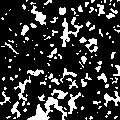
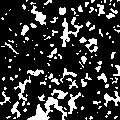
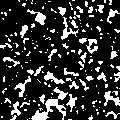
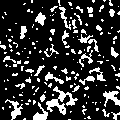
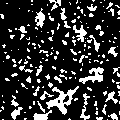
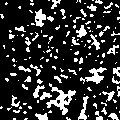
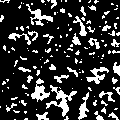
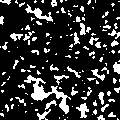
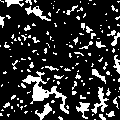
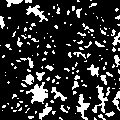
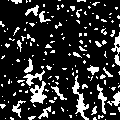
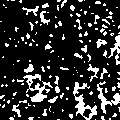
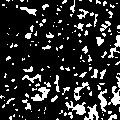
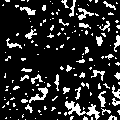
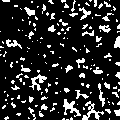
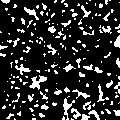
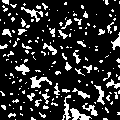
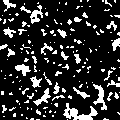
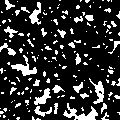
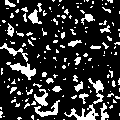
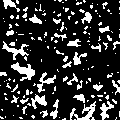
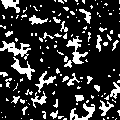
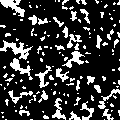
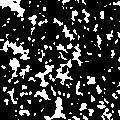
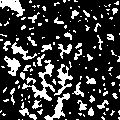
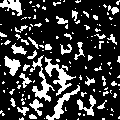
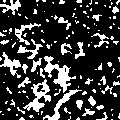
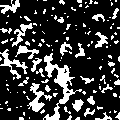
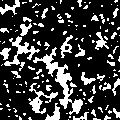
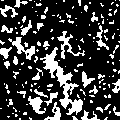
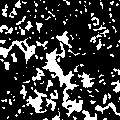
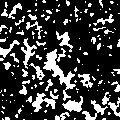
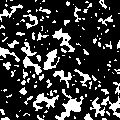
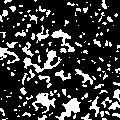
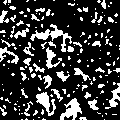
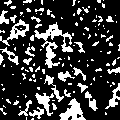
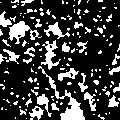
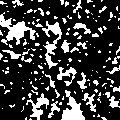
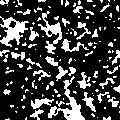
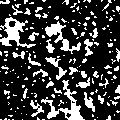
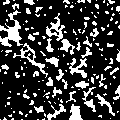
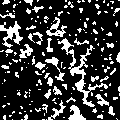
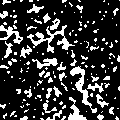
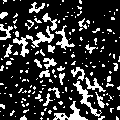
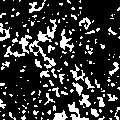
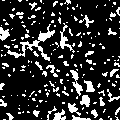
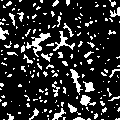
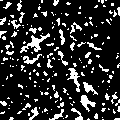
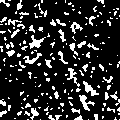
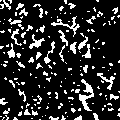
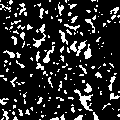
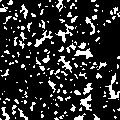
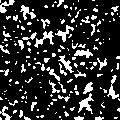
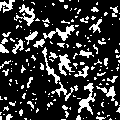
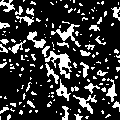
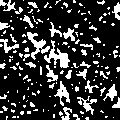
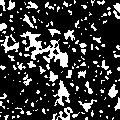
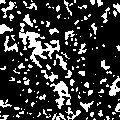
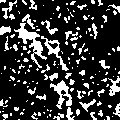
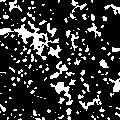
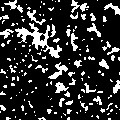
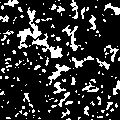
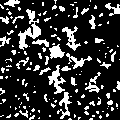
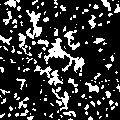
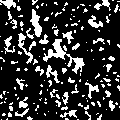
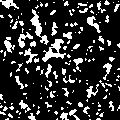
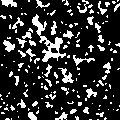
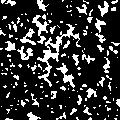
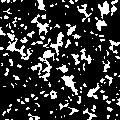
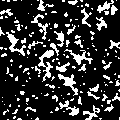
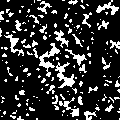
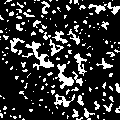
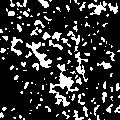
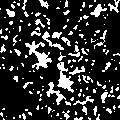
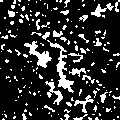
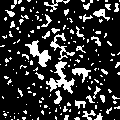
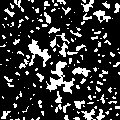
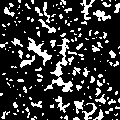
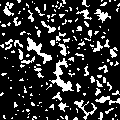
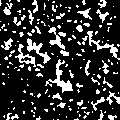
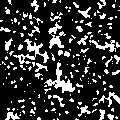
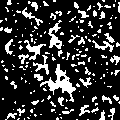
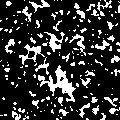
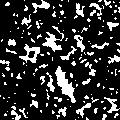
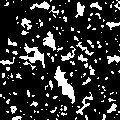
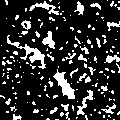
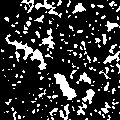
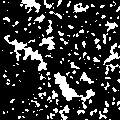
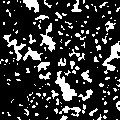
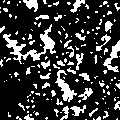
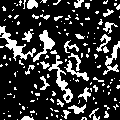
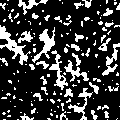
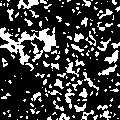
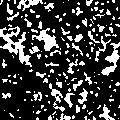
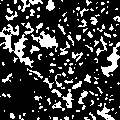
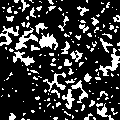
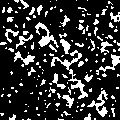
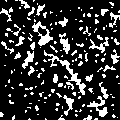
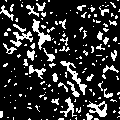
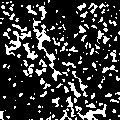
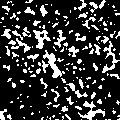
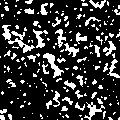
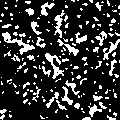
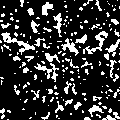
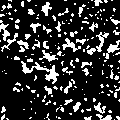
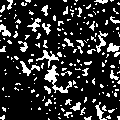
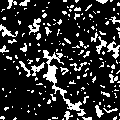
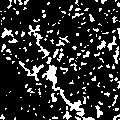
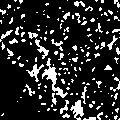
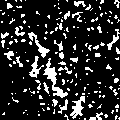
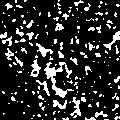
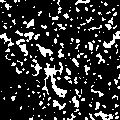
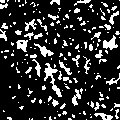
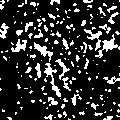
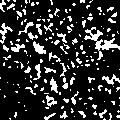
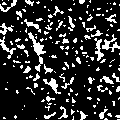
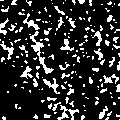
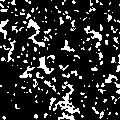
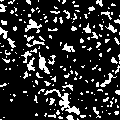
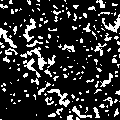
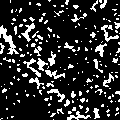

In [23]:
ts_ds = Stone(images_dir=um1_bin_paths,
                label_xlx=lb_file_2,
                transformers=None)
ts_data,ts_lb = ts_ds[np.random.randint(0,len(ts_ds))]
print("Permeability: ",ts_lb.item())
fig = px.imshow(ts_data, animation_frame=0, binary_string=True, labels=dict(animation_frame="scan"), height=600)
fig.show()

## Trainer

In [24]:
class BaseTrain:
    def __init__(self, *args, **kwargs):
        super(BaseTrain).__init__(*args, **kwargs)

    @flush_and_gc
    def train_step(self, **kwargs):
        raise NotImplementedError

    @flush_and_gc
    def validation_step(self, **kwargs):
        raise NotImplementedError

    def train(self, **kwargs):
        raise NotImplementedError


class TrainerV1(BaseTrain):
    def __init__(self, *args, **kwargs):
        super(TrainerV1, self).__init__()
        self._model = kwargs["model"]
        self._device = kwargs["device"]
        self._criterion = kwargs["criterion"]()
        self._opt = kwargs["opt"]
        self._scheduler = kwargs["scheduler"]

        self._model.to(self._device)
        self._opt = self._opt(self._model.parameters(),
                              lr=kwargs["lr"],
                              weight_decay=kwargs["weight_decay"])
        self._scheduler = self._scheduler(self._opt,
                                          step_size=3,
                                          gamma=0.1)
        
    @property
    def model(self):
        return self._model

    @flush_and_gc
    def train_step(self, **kwargs):
        data, lb = kwargs["batch"]
        data = data.to(self._device)
        lb = torch.unsqueeze(lb, dim=-1)
        lb = lb.float().to(self._device)
        loss = self._criterion(self._model(data), lb)
        self._opt.zero_grad()
        loss.backward()
        self._opt.step()
        return loss.item()

    @flush_and_gc
    def validation_step(self, **kwargs):
        data, lb = kwargs["batch"]
        data = data.to(self._device)
        lb = torch.unsqueeze(lb, dim=-1)
        lb = lb.float().to(self._device)
        return self._criterion(self._model(data), lb).item()

    def train(self, **kwargs):
        print(f"-> Training is now starting")
        train_ld = kwargs["train_ld"]
        dev_ld = kwargs["dev_ld"]
        epoch_idx = kwargs["epoch_idx"]
        model_phase = kwargs["model_phase"]
        cpt_dir = kwargs["cpk_dir"]
        save_iter = kwargs["save_iter"]
        con_results = kwargs["cont_results"]
        last_glob_t_loss = kwargs["last_glob_t_loss"]
        last_glob_d_loss = kwargs["last_glob_d_loss"]

        glob_t_loss = [] if last_glob_t_loss is None else last_glob_t_loss
        glob_d_loss = [] if last_glob_d_loss is None else last_glob_d_loss

        epochs = kwargs["epochs"]
        glob_step = 0
        for epoch in range(epoch_idx,epochs):
            tm_t_loss = []
            prefix = f"[{epoch + 1}|{epochs}] epoch,"

            # train step
            self._model.train()
            for batch_idx, batch in enumerate(train_ld):
                ls = self.train_step(batch=batch)
                tm_t_loss.append(ls)

                # show the result
                if (glob_step + 1) % 10 == 0:
                    print(f"{prefix} [{batch_idx}] batch, Loss -> train: {tm_t_loss[-1]}")

                if (glob_step +1)%save_iter == 0:
                    torch.save({
                        "model_phase": model_phase,
                        "epoch_idx":epoch,
                        "model":self.model.state_dict(),
                        "opt":self._opt.state_dict(),
                        "resluts":con_results,
                        "glob_t_loss":glob_t_loss,
                        "glob_d_loss":glob_d_loss
                    },cpt_dir.joinpath(f"model.pt"))

                glob_step += 1


            glob_t_loss.append(np.array(tm_t_loss).mean())
            self._scheduler.step()

            # validation step
            tm_d_loss = []
            self._model.eval()
            with torch.no_grad():
                for batch_idx, batch in enumerate(dev_ld):
                    ls = self.validation_step(batch=batch)
                    tm_d_loss.append(ls)

            glob_d_loss.append(np.array(tm_d_loss).mean())

            print(f"{prefix}, Loss -> train: {glob_t_loss[-1]}, dev: {glob_d_loss[-1]}")
        return {"train_loss":np.array(glob_t_loss),"dev_loss":np.array(glob_d_loss)}

    def save(self, **kwargs):
        torch.save(self._model.state_dict(), str(kwargs["save_path"].joinpath("model.pth")))

### Load Checkpoint

In [25]:
if has_cpt:
    cpt_dic = torch.load(str(checkpoint_dir.joinpath("model.pt")))
  
    idx = cpt_dic["model_phase"]
    epoch_idx = cpt_dic["epoch_idx"]
    model_state_dic = cpt_dic["model"]
    opt_state_dic = cpt_dic["opt"]
    results = cpt_dic["resluts"]
    last_glob_d_loss = cpt_dic["glob_d_loss"]
    last_glob_t_loss = cpt_dic["glob_t_loss"]
else:
    idx = 0
    epoch_idx = 0
    results = []
    last_glob_d_loss = None
    last_glob_t_loss = None

## Train

In [26]:
path_sequence = (
#     ("Um1-Dist",um1_dist_paths),
#      ("Um2-Dist",um2_dist_paths),
#                  ("Um3-Dist",um3_dist_paths),
#                  ("Um1-Bin",um1_bin_paths),
#                  ("Um2-Bin",um2_bin_paths),
                 ("Um3-Bin",um3_bin_paths),)

In [ ]:
criterion = LOSS_FACTORY["rmse"]
opt = Adam
scheduler = StepLR

model = Model3DV1(n_channels=1, n_feature=N_FEATURE_MAP)
if has_cpt:
    model.load_state_dict(model_state_dic)



for _ in range(idx,len(path_sequence)):
    (name,p) = path_sequence[idx]
    dataset = Stone(images_dir=p,
                        label_xlx=lb_file_2,
                        transformers=get_transforms(p_hor=random_h_flip_prob,
                                                    p_ver=random_v_flip_prob,
                                                    r_degree=random_degree_rotate_prob,
                                                    n_channel=n_channel
                                                    ))
    train_size = int(len(dataset) * train_size_per)
    dev_size = len(dataset) - train_size
    train_set, dev_set = random_split(dataset, [train_size, dev_size])
    
    train_loader = DataLoader(train_set,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=n_worker)
    dev_loader = DataLoader(dev_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=n_worker)
    
    res_cont = {}
    res_cont["name"]=name
    print(f"[Trainer {idx+1}] Name: {name}")
    trainer = TrainerV1(model=model,
                        criterion=criterion,
                        opt=opt,
                        scheduler=scheduler,
                        device=device,
                        weight_decay=WEIGHT_DECAY,
                        lr=LR,
                        momentum=MOMENTUM)
    res = trainer.train(train_ld=train_loader, 
                        dev_ld=dev_loader, 
                        epochs=EPOCHS,
                        epoch_idx = epoch_idx if has_cpt else 0,
                        model_phase = idx,
                        cpk_dir=checkpoint_dir,
                        save_iter = save_iter,
                        cont_results = results,
                        last_glob_t_loss = last_glob_t_loss,
                        last_glob_d_loss = last_glob_d_loss)
    has_cpt = False
    last_glob_t_loss = None
    last_glob_d_loss = None
    idx+=1
    res_cont["results"] = res
    results.append(res_cont)
    model = trainer.model 
    trainer.save(save_path = output_dir)

[Trainer 1] Name: Um3-Bin
-> Training is now starting
[1|30] epoch, [9] batch, Loss -> train: 5.709133148193359
[1|30] epoch, [19] batch, Loss -> train: 5.4200639724731445
[1|30] epoch, [29] batch, Loss -> train: 31.922760009765625
[1|30] epoch, [39] batch, Loss -> train: 15.425970077514648
[1|30] epoch, [49] batch, Loss -> train: 34.20341491699219
[1|30] epoch, [59] batch, Loss -> train: 3.2417497634887695
[1|30] epoch, [69] batch, Loss -> train: 4.410152435302734
[1|30] epoch, [79] batch, Loss -> train: 6.574069976806641
[1|30] epoch, [89] batch, Loss -> train: 54.386329650878906
[1|30] epoch, [99] batch, Loss -> train: 7.017660140991211
[1|30] epoch, [109] batch, Loss -> train: 46.48371124267578
[1|30] epoch, [119] batch, Loss -> train: 5.672920227050781
[1|30] epoch, [129] batch, Loss -> train: 3.419186592102051
[1|30] epoch, [139] batch, Loss -> train: 5.328913688659668
[1|30] epoch, [149] batch, Loss -> train: 5.997311115264893
[1|30] epoch, [159] batch, Loss -> train: 6.02317142

[7|30] epoch, [27] batch, Loss -> train: 5.084246635437012
[7|30] epoch, [37] batch, Loss -> train: 6.790771484375
[7|30] epoch, [47] batch, Loss -> train: 4.60344123840332
[7|30] epoch, [57] batch, Loss -> train: 15.133041381835938
[7|30] epoch, [67] batch, Loss -> train: 31.694473266601562
[7|30] epoch, [77] batch, Loss -> train: 2.2894935607910156
[7|30] epoch, [87] batch, Loss -> train: 0.5508518218994141
[7|30] epoch, [97] batch, Loss -> train: 41.506099700927734
[7|30] epoch, [107] batch, Loss -> train: 3.724559783935547
[7|30] epoch, [117] batch, Loss -> train: 1.8602008819580078
[7|30] epoch, [127] batch, Loss -> train: 3.7221879959106445
[7|30] epoch, [137] batch, Loss -> train: 0.1340045928955078
[7|30] epoch, [147] batch, Loss -> train: 19.884679794311523
[7|30] epoch, [157] batch, Loss -> train: 0.5286769866943359
[7|30] epoch, [167] batch, Loss -> train: 26.02386474609375
[7|30] epoch, [177] batch, Loss -> train: 5.167581558227539
[7|30] epoch, [187] batch, Loss -> train: 

[13|30] epoch, [45] batch, Loss -> train: 20.50620460510254
[13|30] epoch, [55] batch, Loss -> train: 0.7632293701171875
[13|30] epoch, [65] batch, Loss -> train: 15.041425704956055
[13|30] epoch, [75] batch, Loss -> train: 40.45118713378906
[13|30] epoch, [85] batch, Loss -> train: 5.925037384033203
[13|30] epoch, [95] batch, Loss -> train: 0.6861667633056641
[13|30] epoch, [105] batch, Loss -> train: 22.52178382873535
[13|30] epoch, [115] batch, Loss -> train: 6.431417465209961
[13|30] epoch, [125] batch, Loss -> train: 1.4177989959716797
[13|30] epoch, [135] batch, Loss -> train: 1.03009033203125
[13|30] epoch, [145] batch, Loss -> train: 3.5275373458862305
[13|30] epoch, [155] batch, Loss -> train: 36.11019515991211
[13|30] epoch, [165] batch, Loss -> train: 3.06057071685791
[13|30] epoch, [175] batch, Loss -> train: 22.409881591796875
[13|30] epoch, [185] batch, Loss -> train: 2.9306106567382812
[13|30] epoch, [195] batch, Loss -> train: 5.9851837158203125
[13|30] epoch, [205] bat

[19|30] epoch, [53] batch, Loss -> train: 1.1397647857666016
[19|30] epoch, [63] batch, Loss -> train: 1.349935531616211
[19|30] epoch, [73] batch, Loss -> train: 4.496148109436035
[19|30] epoch, [83] batch, Loss -> train: 1.5580520629882812
[19|30] epoch, [93] batch, Loss -> train: 4.539833068847656
[19|30] epoch, [103] batch, Loss -> train: 5.142374038696289
[19|30] epoch, [113] batch, Loss -> train: 1.1484794616699219
[19|30] epoch, [123] batch, Loss -> train: 1.142674446105957
[19|30] epoch, [133] batch, Loss -> train: 1.961019515991211
[19|30] epoch, [143] batch, Loss -> train: 4.635125160217285
[19|30] epoch, [153] batch, Loss -> train: 2.8266448974609375
[19|30] epoch, [163] batch, Loss -> train: 0.20021343231201172
[19|30] epoch, [173] batch, Loss -> train: 2.6992835998535156
[19|30] epoch, [183] batch, Loss -> train: 2.4025192260742188
[19|30] epoch, [193] batch, Loss -> train: 6.200352668762207
[19|30] epoch, [203] batch, Loss -> train: 5.589044570922852
[19|30] epoch,, Loss 

[25|30] epoch, [51] batch, Loss -> train: 7.793437957763672
[25|30] epoch, [61] batch, Loss -> train: 21.93809700012207
[25|30] epoch, [71] batch, Loss -> train: 4.982509613037109
[25|30] epoch, [81] batch, Loss -> train: 8.96330451965332
[25|30] epoch, [91] batch, Loss -> train: 41.24595642089844
[25|30] epoch, [101] batch, Loss -> train: 40.30359649658203
[25|30] epoch, [111] batch, Loss -> train: 2.703306198120117
[25|30] epoch, [121] batch, Loss -> train: 6.967104434967041
[25|30] epoch, [131] batch, Loss -> train: 3.7541017532348633
[25|30] epoch, [141] batch, Loss -> train: 6.295923233032227
[25|30] epoch, [151] batch, Loss -> train: 18.403350830078125
[25|30] epoch, [161] batch, Loss -> train: 8.29661750793457
[25|30] epoch, [171] batch, Loss -> train: 23.068212509155273
[25|30] epoch, [181] batch, Loss -> train: 5.014680862426758
[25|30] epoch, [191] batch, Loss -> train: 4.82103157043457
[25|30] epoch, [201] batch, Loss -> train: 0.167266845703125
[25|30] epoch, [211] batch, L

## Plot learning curve

In [31]:
plt.style.use('ggplot')

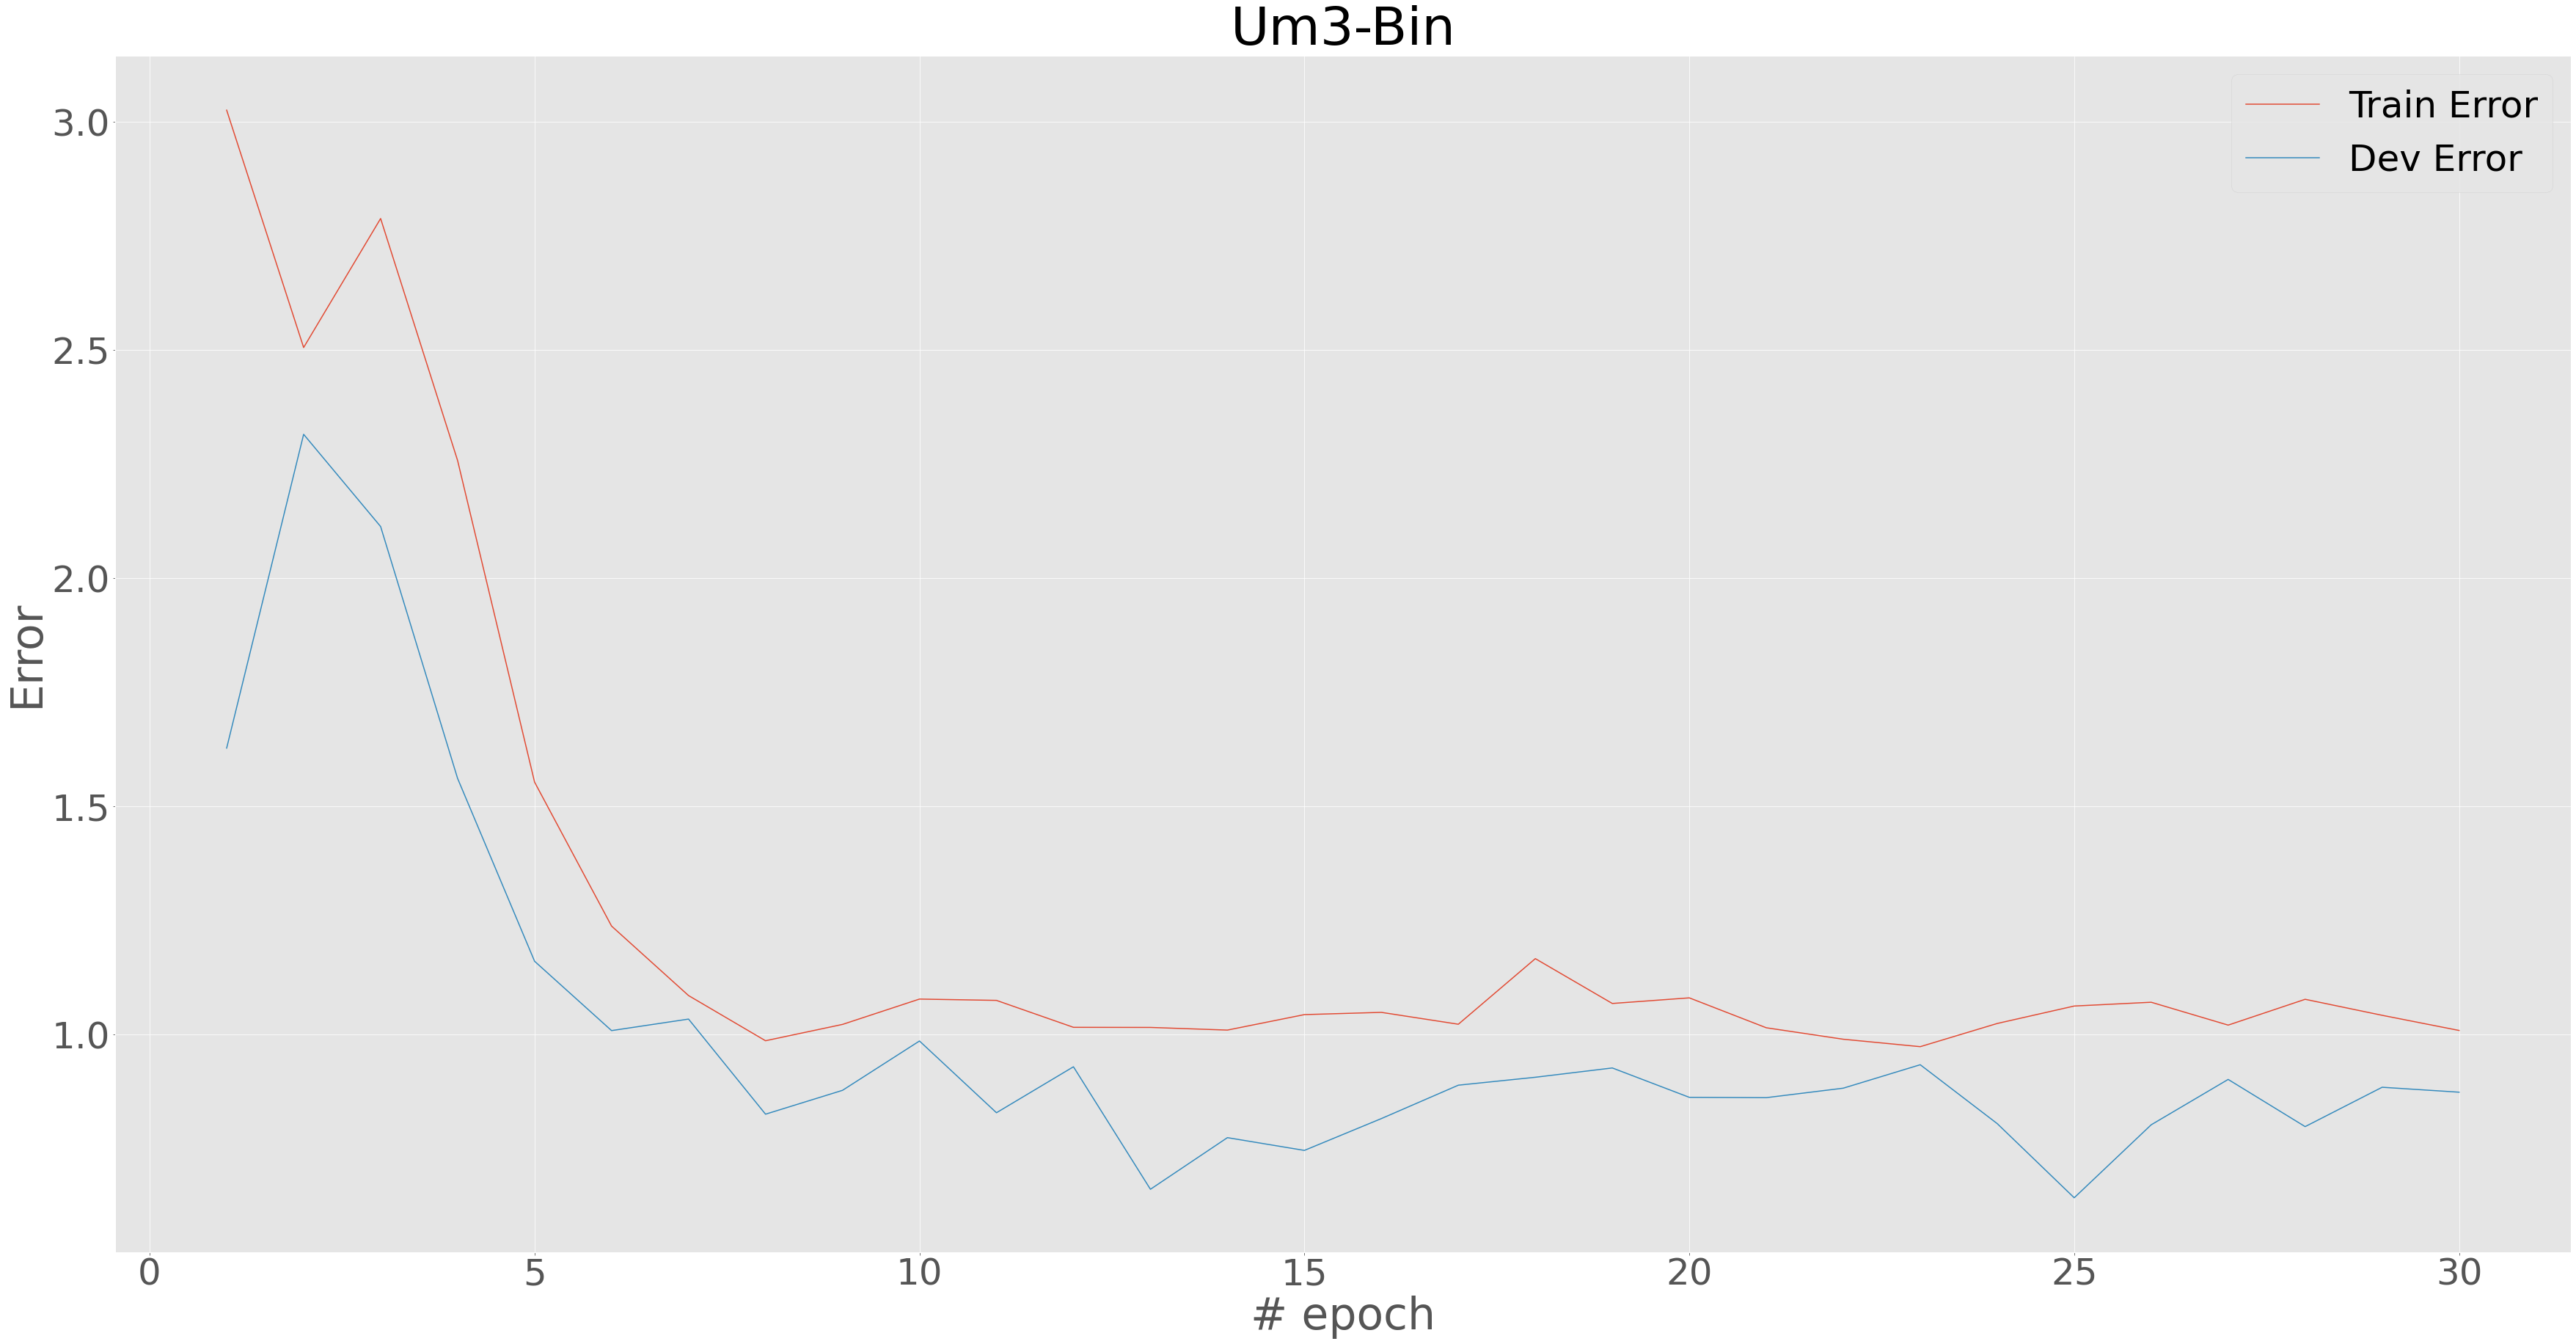

In [33]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (60,30*len(results))

font = {'size'   : 50}

matplotlib.rc('font', **font)
fig,axes = plt.subplots(len(results),1)

if len(results) == 1:
    axes.set_title(res["name"])
    axes.plot(np.arange(EPOCHS)+1,res["results"]["train_loss"],label="Train Error")
    axes.plot(np.arange(EPOCHS)+1,res["results"]["dev_loss"],label="Dev Error")
    axes.set_xlabel("# epoch")
    axes.set_ylabel("Error")
    axes.legend()



else:
    for idx,res in enumerate(results):
        axes[idx].set_title(res["name"])
        axes[idx].plot(np.arange(EPOCHS)+1,res["results"]["train_loss"],label="Train Error")
        axes[idx].plot(np.arange(EPOCHS)+1,res["results"]["dev_loss"],label="Dev Error")
        axes[idx].set_xlabel("# epoch")
        axes[idx].set_ylabel("Error")
        axes[idx].legend()


plt.show()

## Show some result
> plot show prediction on unseen data

In [35]:
# model_path = Path("/home/lizard/Documents/Code/Project/stoneRegression/cpt/20211226-024625/model.pt")
model_path = None
if model_path is not None:
    model = Model3DV1(n_channels=1, n_feature=N_FEATURE_MAP)
    model_state_dict = torch.load(model_path)
    model.load_state_dict(model_state_dict["model"])
    
    model.to(device)
    
    dataset = Stone(images_dir=path_sequence[2][1],
                        label_xlx=lb_file_2,
                        transformers=get_transforms(p_hor=random_h_flip_prob,
                                                    p_ver=random_v_flip_prob,
                                                    r_degree=random_degree_rotate_prob,
                                                    n_channel=n_channel
                                                    ))
    
    train_size = int(len(dataset) * train_size_per)
    dev_size = len(dataset) - train_size
    train_set, dev_set = random_split(dataset, [train_size, dev_size])
    
    train_loader = DataLoader(train_set,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=n_worker)
    dev_loader = DataLoader(dev_set,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=n_worker)
    

In [36]:
with torch.no_grad():
    ts_data,ts_lb = dev_set[np.random.randint(0,len(dev_set))]
    ts_data = ts_data.to(device)
    model.eval()
    ts_pred = model(torch.unsqueeze(ts_data,axis=0))


True Permeability: 5.8255778445541795, Predicted Permeability: 4.419321060180664



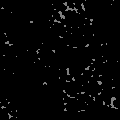
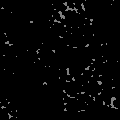
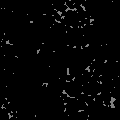
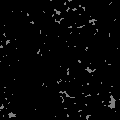
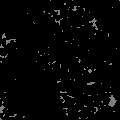
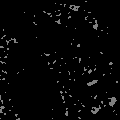
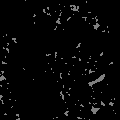
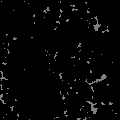
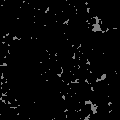
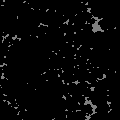
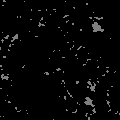
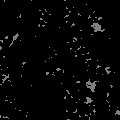
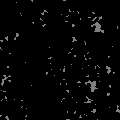
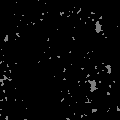
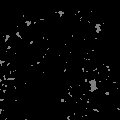
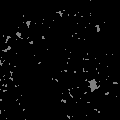
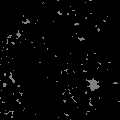
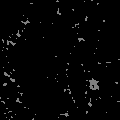
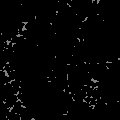
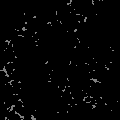
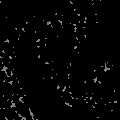
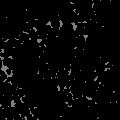
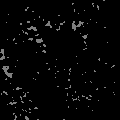
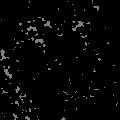
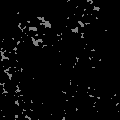
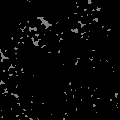
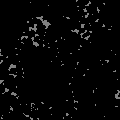
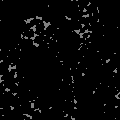
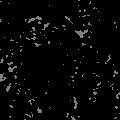
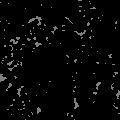
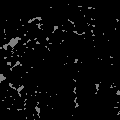
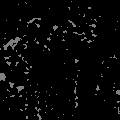
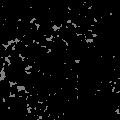
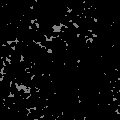
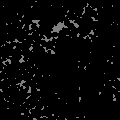
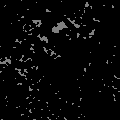
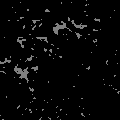
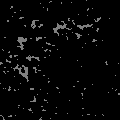
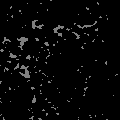
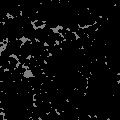
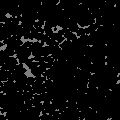
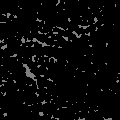
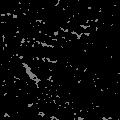
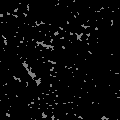
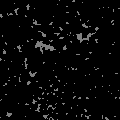
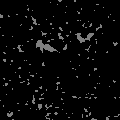
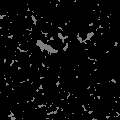
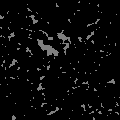
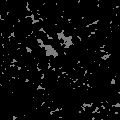
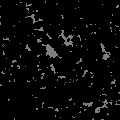
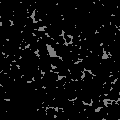
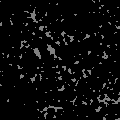
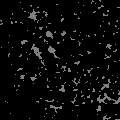
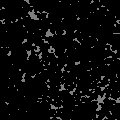
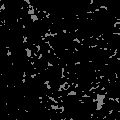
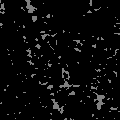
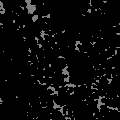
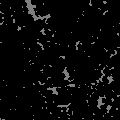
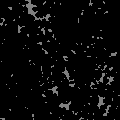
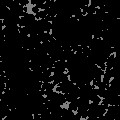
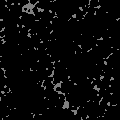
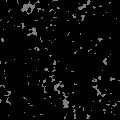
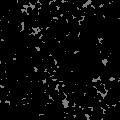
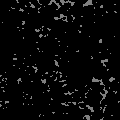
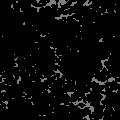
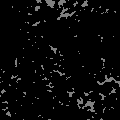
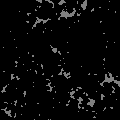
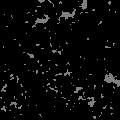
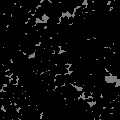
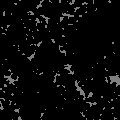
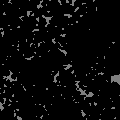
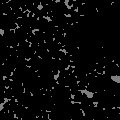
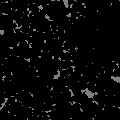
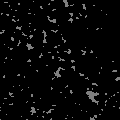
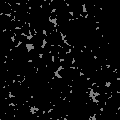
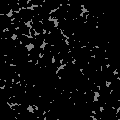
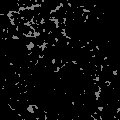
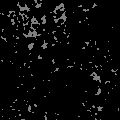
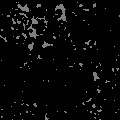
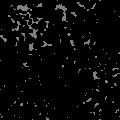
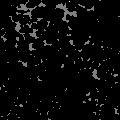
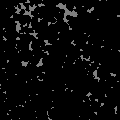
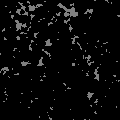
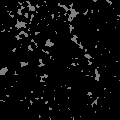
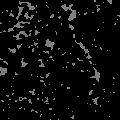
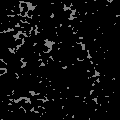
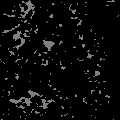
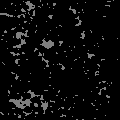
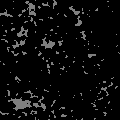
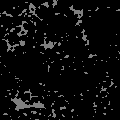
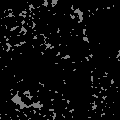
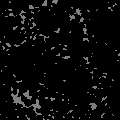
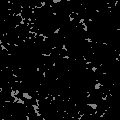
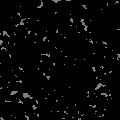
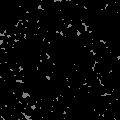
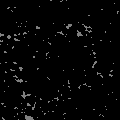
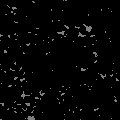
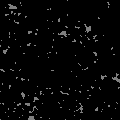
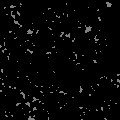
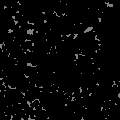
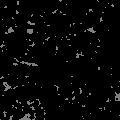
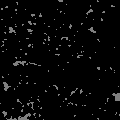
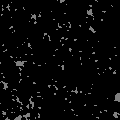
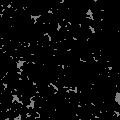
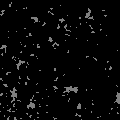
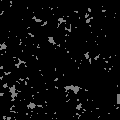
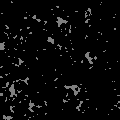
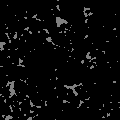
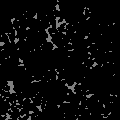
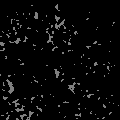
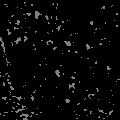
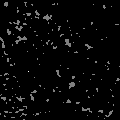
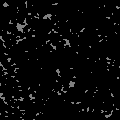
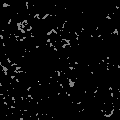
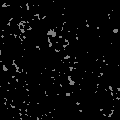
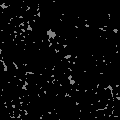
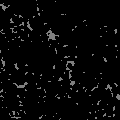
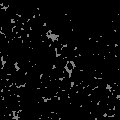
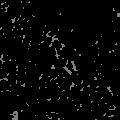
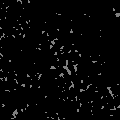
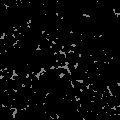

In [37]:
ts_data_list = np.squeeze(ts_data.cpu(),0).numpy()
print(f"True Permeability: {ts_lb.item()}, Predicted Permeability: {ts_pred[0][0]}")
fig = px.imshow(ts_data_list, animation_frame=0, binary_string=True, labels=dict(animation_frame="scan"), height=600)
fig.show()

In [38]:
pred_prem = []
true_perm = []
model.eval()
for idx in range(len(dev_set)):
    with torch.no_grad():
#         print(f"=> {idx}")
        data,lb = dev_set[idx]
        data = data.to(device)
        true_perm.append(lb.item())
        ts_pred = model(torch.unsqueeze(data,axis=0))
#         print(ts_pred)
        pred_prem.append(ts_pred.cpu().tolist())

In [39]:
prediction = np.squeeze(np.squeeze(np.array(pred_prem),axis=-1),axis=-1)
true_value = np.array(true_perm)

In [40]:
def r_fn(y_pred,y_true):
    n = y_true.shape[0]
    sum_tot = np.sum(np.power(np.subtract(y_true, np.mean(y_true)), 2))
    sum_reg = np.sum(np.power(np.subtract(y_pred, np.mean(y_true)), 2))
    return np.abs(1-np.divide(sum_reg, sum_tot))

r_coeff = r_fn(prediction,true_value)

In [41]:
item_list = list(zip(true_value,prediction))
item_list.sort(key=lambda tu:tu[0])
true_value = [round(tu[0],3)for tu in item_list]
prediction = [tu[1]for tu in item_list]
coef = r2_score(true_value,prediction)

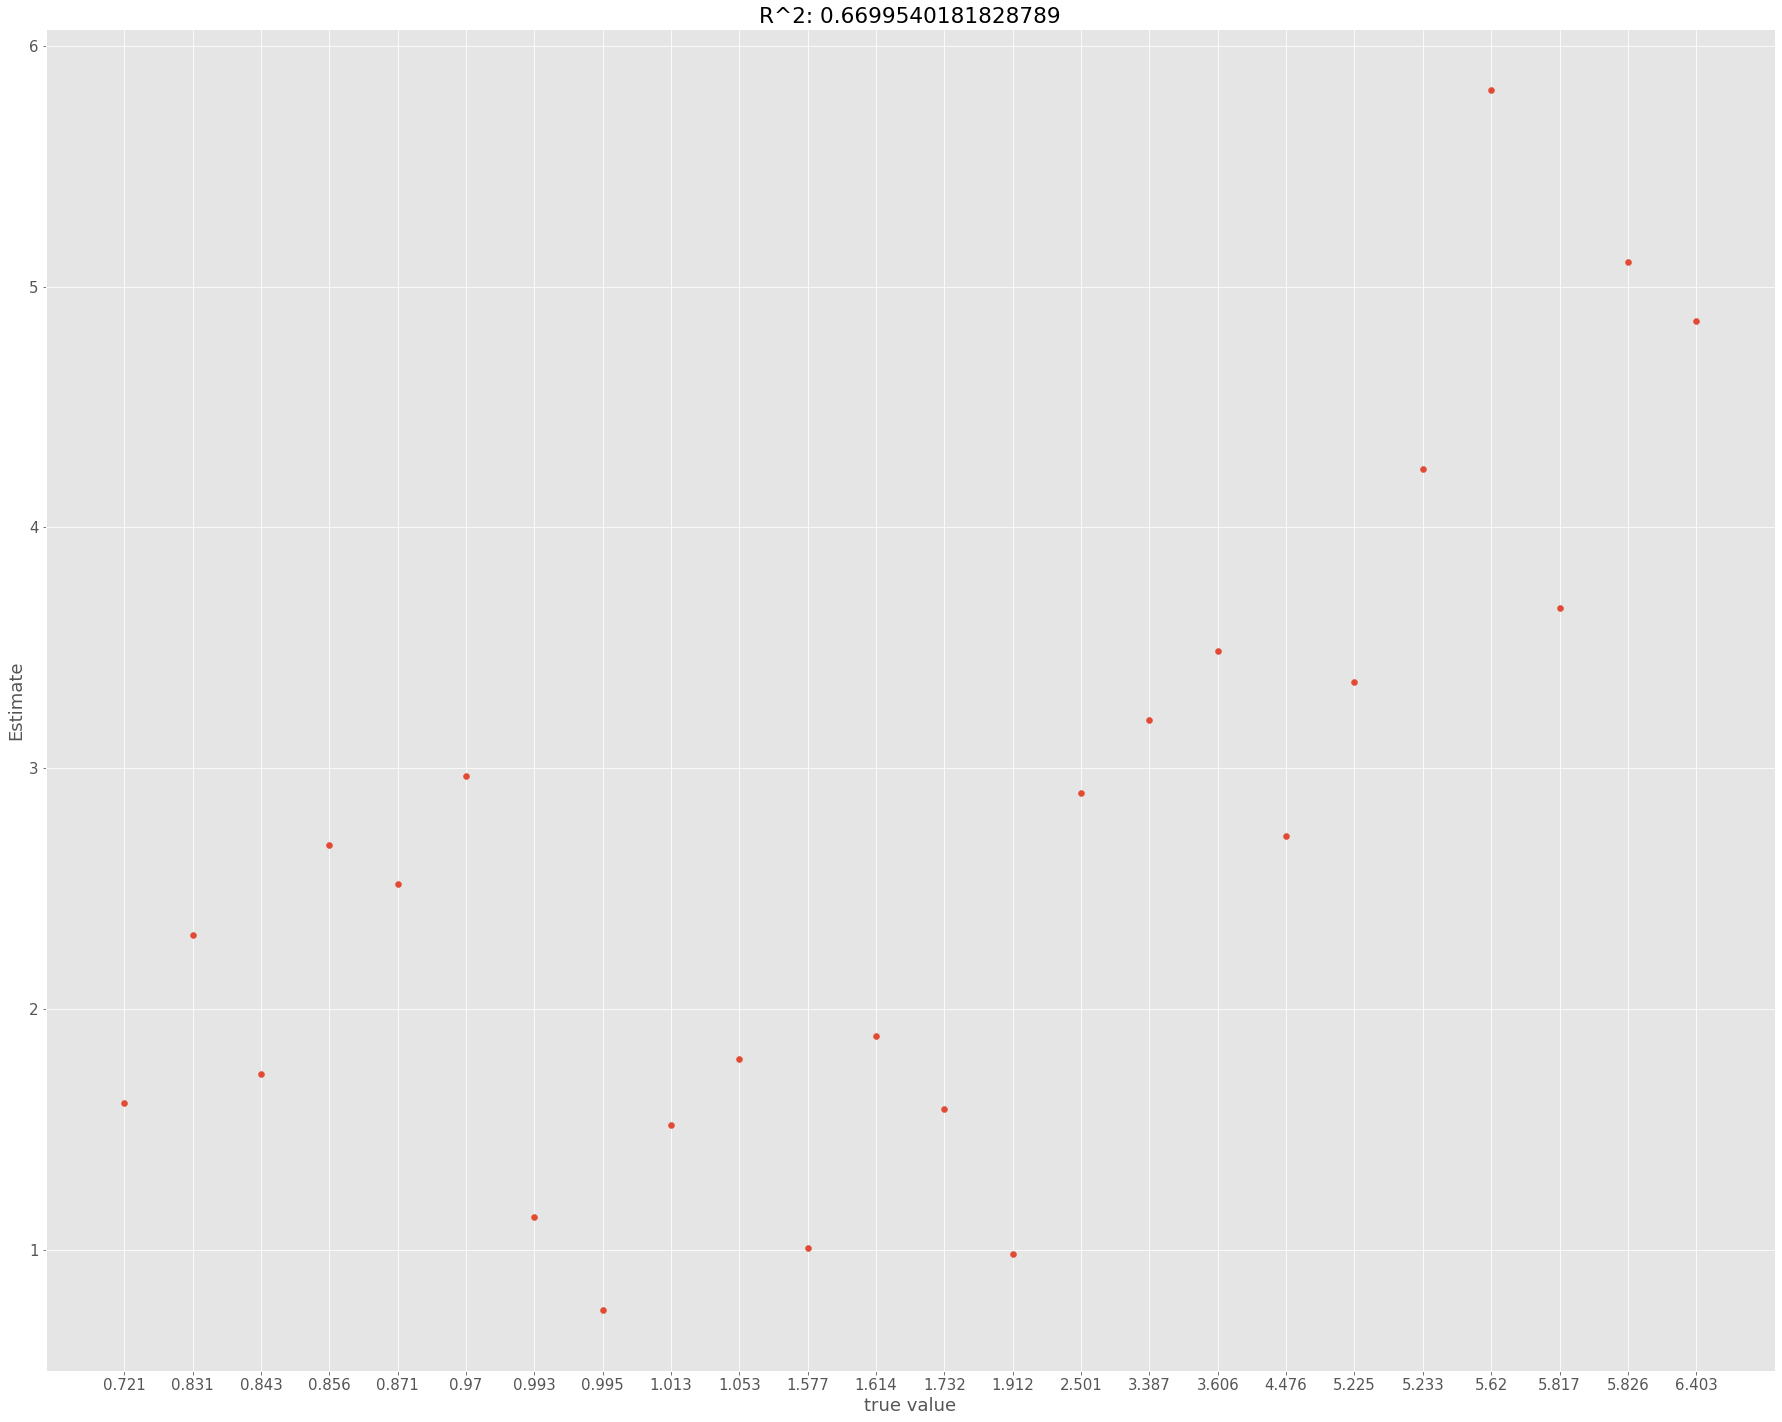

In [42]:
plt.rcParams["figure.figsize"] = [25, 20]
plt.rcParams["figure.autolayout"] = True
font = {'size'   : 15}

matplotlib.rc('font', **font)
plt.title(f"R^2: {max(r_coeff,np.abs(coef))}")
default_x_ax = np.arange(len(true_value))+1
plt.scatter(default_x_ax,prediction)
plt.xticks(default_x_ax, true_value)
plt.ylabel("Estimate")
plt.xlabel("true value")
plt.show()

In [ ]:
diffs = 0
scale = 1
for idx,(real,pred) in enumerate(zip(true_value,prediction)):
    real = real*scale
    pred = pred*scale
    print(f"{idx+1}: real-> {real}, pred -> {pred}")